In [1]:
def predict2(file_name=None):
    if not file_name:
        file_name = record_path
        
    trimmed_path = 'temp/trimmed.wav'
    sound = AudioSegment.from_file(file_name, format='wav')
    normalizedsound = effects.normalize(sound)
    normalizedsound.export(trimmed_path, format='wav')
    
    rate, data = read(trimmed_path)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    write(trimmed_path, rate, reduced_noise)
    
    record_mfcc = get_mfcc(trimmed_path)
    scores = [model[cname].score(record_mfcc) for cname in class_names]
    predict_word = np.argmax(scores)
    print(class_names[predict_word])

In [2]:
import pickle
import wave
import librosa
import math
import numpy as np
import pyaudio
from pydub import AudioSegment, effects
import sounddevice as sd
from scipy.io.wavfile import write, read
import noisereduce as nr

model = {}

#class_names = ['bat', 'tat', 'thiet', 'bi', 'mot', 'hai', 'ba', 'bon']
class_names = ['bat', 'tat', 'mot', 'hai', 'ba', 'sheila', 'den', 'quat']
audio_format = 'wav'

record_path = 'temp/record.wav'
trimmed_path = 'temp/trimmed.wav'
model_path = 'models_train_main'

def get_mfcc(file_path):
    y, sr = librosa.load(file_path)  # read .wav file
       
    hop_length = math.floor(sr * 0.010)  # 10ms hop
    win_length = math.floor(sr * 0.025)  # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=12, n_fft=1024, 
        hop_length=hop_length, win_length=win_length)
    # subtract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1))
    # delta feature 1st order and 2nd order
#     delta1 = librosa.feature.delta(mfcc, order=1)
#     delta2 = librosa.feature.delta(mfcc, order=2)
    delta1 = librosa.feature.delta(mfcc, mode='nearest',order=1)
    delta2 = librosa.feature.delta(mfcc, mode='nearest',order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0)  # O^r
    # return T x 36 (transpose of X)
    return X.T  # hmmlearn use T x N matrix


def detect_leading_silence(sound, silence_threshold=-42.0, chunk_size=10):
        trim_ms = 0  # ms
        assert chunk_size > 0  # to avoid infinite loop
        while sound[trim_ms:trim_ms + chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
            trim_ms += chunk_size
        return trim_ms

for key in class_names:
    name = f"{model_path}/model_{key}.pkl"
    with open(name, 'rb') as file:
        model[key] = pickle.load(file)

def predict(file_name=None):
    if not file_name:
        file_name = record_path
        
    trimmed_path = 'temp/trimmed.wav'
    sound = AudioSegment.from_file(file_name, format='wav')
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    #print(str(start_trim) + " - " + str(duration - end_trim))

    if start_trim >= 800:
        print("XXX")
        return
    # if duration - end_trim - start_trim > 700:
    #     print("XXX")
    #     return
    if duration - end_trim - start_trim < 100:
        print("XXX")
        return
    normalizedsound = effects.normalize(sound)
    normalizedsound.export(trimmed_path, format='wav')
    
    rate, data = read(trimmed_path)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    write(trimmed_path, rate, reduced_noise)
    
    sound = AudioSegment.from_file(trimmed_path, format='wav')
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    print(str(start_trim) + " - " + str(duration - end_trim))
#     if start_trim > 200:
#         start_trim -= 200
#     else: 
#         start_trim = 0
    trimmed_sound = sound[start_trim:duration - end_trim]
    #trimmed_sound = sound[:]
    trimmed_sound.export(trimmed_path, format='wav')

    if start_trim >= 800 or start_trim == 0:
        print("XXX")
        return
    # if duration - end_trim - start_trim > 700:
    #     print("XXX")
    #     return
    # if duration - end_trim - start_trim < 200:
    #     print("XXX")
    #     return
    # Predict
    record_mfcc = get_mfcc(trimmed_path)
    scores = [model[cname].score(record_mfcc) for cname in class_names]
    predict_word = np.argmax(scores)
    print(class_names[predict_word])
    return class_names[predict_word]


RATE = 16000
RECORD_SECONDS = 1
while True:
    print("------------")
    myrecording = sd.rec(int(RECORD_SECONDS * RATE), channels=1, samplerate=RATE, dtype='int16')
    sd.wait()
    write(record_path, RATE, myrecording)
    predict(record_path)

------------
XXX
------------
XXX
------------
XXX
------------
XXX
------------
XXX
------------


KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
myrecording = sd.rec(int(5 * RATE), channels=1, samplerate=RATE, dtype='int16')
sd.wait()
write(record_path, RATE, myrecording)

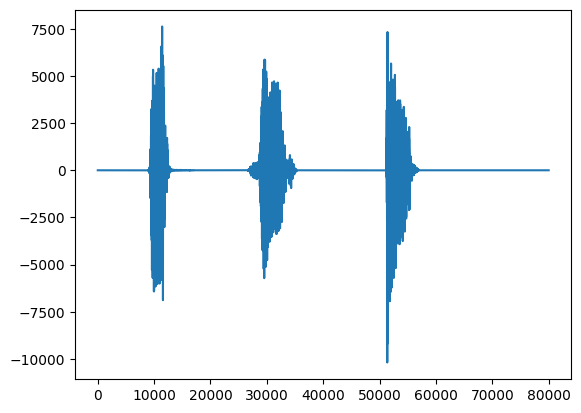

In [29]:
plt.plot(myrecording)
write(record_path, RATE, myrecording)


250 320
260 - 460
quat
180 - 540
ba
220 - 480
bat
['quat', 'ba', 'bat']


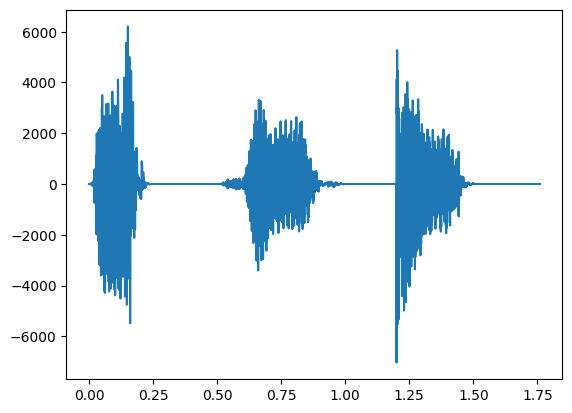

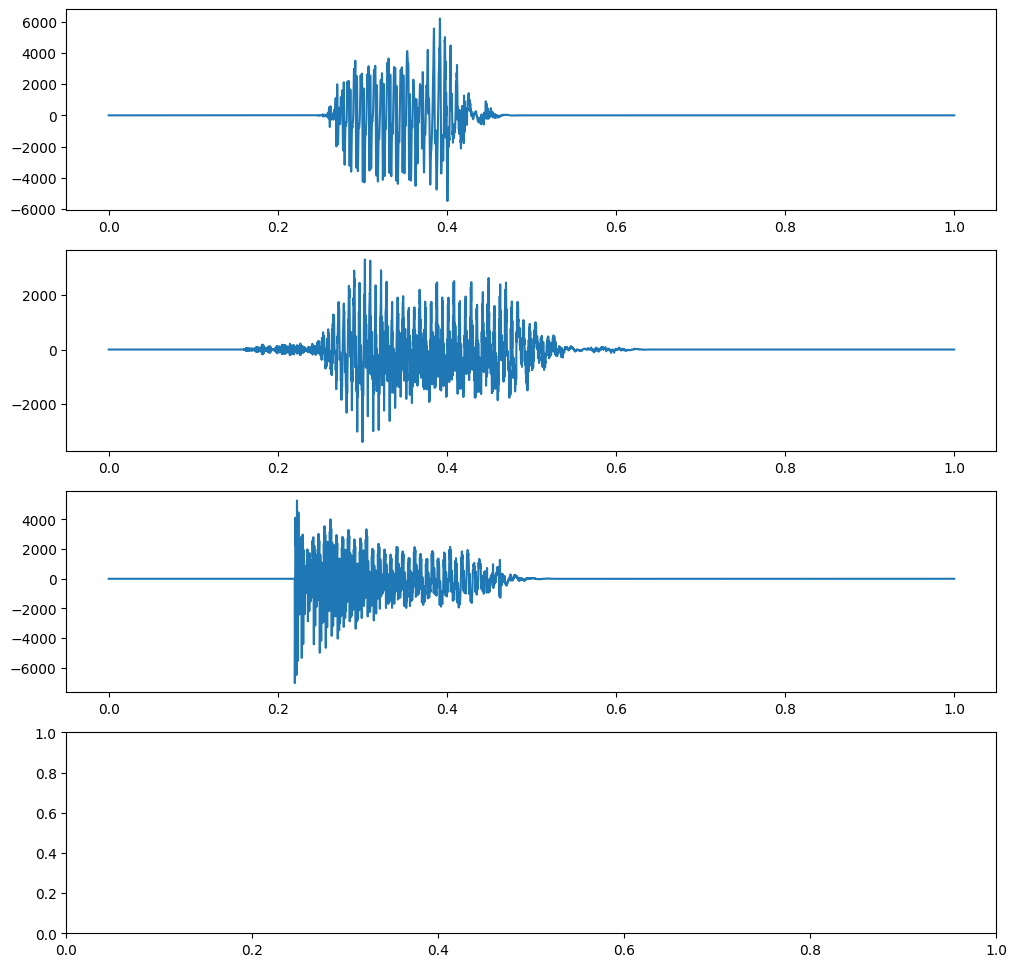

In [30]:
import webrtcvad
import struct
vad = webrtcvad.Vad()
vad.set_mode(1)
DURATION = 5
FRAME_LEN = 0.02
def framing(speech_signal, Fs):
    frame_size = round(FRAME_LEN * Fs)
    frame_count = math.floor(len(speech_signal) / frame_size) 
    
    temp = 0
    frame = list()
    for i in range(frame_count):
        frame.append(speech_signal[temp : temp + frame_size]) 
        temp = temp + frame_size + 1

    return frame, frame_size, frame_count

def vad_collector(vad, data):
    triggered = False
    voiced_frames = []
    buf = []
    
    frames, frame_size, frame_count = framing(data, RATE)
    print(frame_count, frame_size)
    empty_frame = [0 for _ in range(frame_size)]

    for i in range(frame_count - 1):
        curr_frame = np.array(frames[i])
        is_speech = vad.is_speech(curr_frame, RATE)
        if is_speech and not triggered:
            buf.append(curr_frame)
            triggered = not triggered 
        
        elif not is_speech and triggered:
            voiced_frames.append(buf)
            buf = []
            triggered = not triggered 
        elif len(buf) != 0 and triggered:
            buf.append(curr_frame)

    return voiced_frames

def drawFrame(frame, frameSize, Fs):
    wave = []
    empty_frame = [0 for _ in range(frameSize)]
    for f in frame:
        for i in range(len(f)):
            for j in range(frameSize):
                wave.append(f[i][j])

    wave = np.asarray(wave)
    t1 = np.linspace(start = 0, stop = len(wave) / Fs, num = len(wave)) #Truc thoi gian x-axis

    plt.plot(t1, wave)
    
def drawFrame1(frame, frameSize, Fs, ax):
    wave = []
    for i in range(len(frame)):
        for j in range(frameSize):
            wave.append(frame[i][j])
    wave = np.asarray(wave)

    t1 = np.linspace(start = 0, stop = len(wave) / Fs, num = len(wave)) #Truc thoi gian x-axis

    ax.plot(t1, wave)

rate, data = read(record_path)
reduced_noise = nr.reduce_noise(y=data, sr=RATE)
y = vad_collector(vad, reduced_noise)
drawFrame(y, 320, RATE)

fig,(ax) = plt.subplots(4,figsize =(12,12))

res = []

for i,f in enumerate(y):
    length = 50 - len(f)
    empty = np.zeros(320, dtype=np.int16)
    
    for _ in range(length//2):
        f.insert(0, empty)
        f.append(empty)
        
    wav = []
    for k in range(len(f)):
        for j in range(320):
            wav.append(f[k][j])
    
    drawFrame1(f, 320, RATE, ax[i])
    write(trimmed_path, RATE, np.array(wav))
    res.append(predict(trimmed_path))
    
print(res)
action = ""
device_name = ""
device_num = ""
for word in res:
    if word == "bat":
        action = "on"
    elif word == "tat":
        action = "off"
    elif word == "den":
        device_name = "Den"
    elif word == "quat":
        device_name = "Quat"
    elif word == "mot":
        device_num = 1
    elif word == "hai":
        device_num = 2
    elif word == "ba":
        device_num = 3
    
    